# Universal part-of-speech tagset and HMM applied to The Cat in the Hat
Henry Chacon

In [1]:
import nltk
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Image
from pprint import pprint 
%matplotlib inline

# To download tokens library run:
# nltk.download()
# from nltk.tokenize import sent_tokenize, word_tokenize

In [30]:
# Function to get the frequency of the emission word per tag
# Input: 
# tag: Penn or uPOS tag. word: emmited word per tag. dictionary: one for PeenTreebank and other for uPOS
# Output: updated dictionary containing the number of word per tag
def word_frequency (tag, word, dictionary):
    if tag in dictionary.keys(): 
        if word in dictionary[tag].keys():
            dictionary[tag][word] = dictionary[tag][word] + 1
        else:
            dictionary[tag][word] = 1
    else:
        dictionary[tag] = {}
        word_frequency(tag, word, dictionary)
    return dictionary


# Function to get the frequency of tag transitions per line
# Input: 
# tag: list with tags per line. dictionary: one for PeenTreebank and other for uPOS
# Output: updated dictionary containing the transition per tag
def transition_frequency(tag_list, dictionary):
    word_frequency('START', tag_list[0], dictionary)
    for i in range(1, len(tag_list)):
        word_frequency(tag_list[i-1], tag_list[i], dictionary)
    word_frequency(tag_list[len(tag_list) - 1], 'END', dictionary) 
    word_frequency('END', 'END', dictionary)
    return dictionary


# Function to produce the transition matrix based on the tags frequencies
# Input: 
# tag: a dictionary: PeenTreebank or uPOS
# Output: df: transition matrix in absolute values. df_prop: transition matrix (proportions)
def transition_matrix(frequencies):
    df = pd.DataFrame(columns=frequencies.keys(), index=frequencies.keys())
    df_prop = pd.DataFrame(columns=frequencies.keys(), index=frequencies.keys())
    for i in frequencies.keys():
        df.loc[i] = frequencies[i]
        df_prop.loc[i] = frequencies[i]
        df_prop.loc[i] = df.loc[i] / sum(frequencies[i].values())
    df = df.fillna(0).astype(int)
    df_prop = df_prop.fillna(0)
    return df, df_prop

## Importing the text file: The Cat in the Hat

In [4]:
# Code section that generates a dictionary from the tags in the PennTreebank (EN).
# Source file: https://github.com/slavpetrov/universal-pos-tags/blob/master/en-brown.map
pos_conv = {}
pos_map = open("en-brown.map", "r")
for line in pos_map:
    cad = str.split(line) 
    pos_conv[cad[0]] = cad[1]
        
pos_map.close()
print("Number of tags found on the en-brown map: {}".format(len(pos_conv)))
# Adding tags in the Universal set of tags since they are not found in the original source
pos_conv['NNP'] = 'NOUN'
pos_conv['PRP'] = 'NOUN'
pos_conv['NNPS'] = 'NOUN'
pos_conv['PDT'] = 'DET'
pos_conv['POS'] = 'PRON'
pos_conv['PRP$'] = 'PRON'
pos_conv['RBS'] = 'ADV'
pos_conv['VBP'] = 'VERB'
pos_conv['WP'] = 'PRON'
pos_conv['FW'] = 'NONE'

Number of tags found on the en-brown map: 472


## PennTree bank and Universal tags correlation

In [5]:
# Section implemented to read the input file and get the frequencies tags

# Input: text file. In this case, Dr. Seuss' book
# Output: 
#    peen_freq = frequency of words per tag, PeenTree tags
#    peen_trans = frequency of transitions per line, PeenTree tags
#    uPOS_freq = frequency of words per tag, universal tags
#    uPOS_trans = frequency of transitions per line, universal tags
#    uPOS_none = list of unmatched tags between PineTree tags and Universal tags


# Reading the book: 'The Cat in the Hat' by Dr Seuss book
# Source file: https://github.com/robertsdionne/rwet/blob/master/hw2/drseuss.txt
book = open("drseuss.txt", "r")
book_lines = book.readlines()

# Tag-word frequencies
peen_freq, uPOS_freq, uPOS_none = {}, {}, []

# Transition matrix
peen_trans, uPOS_trans = {}, {}

for line in book_lines:
    token = nltk.word_tokenize(line)
    if len(token) > 0:
        peen_tag = nltk.pos_tag(token)
        words, tags = zip(*peen_tag)
        words = [x.lower() for x in words]
        pos_tag = [pos_conv.get(x) for x in tags]
        
        for seq in zip(tags, pos_tag, words):
            word_frequency(seq[0], seq[2], peen_freq)
            word_frequency(seq[1], seq[2], uPOS_freq)
            if seq[1] is None:
                uPOS_none.append(seq[0])
        
        # Getting the transition per tag
        transition_frequency(tags, peen_trans)
        transition_frequency(pos_tag, uPOS_trans)
        
        print(line, end = '')
        print(token)
        print('Peen tag: ', list(zip(words, tags)))
        print('uPOS tag: ', list(zip(words, pos_tag)), '\n')
print(len(book_lines))
book_text = book.read()
book.close()

The Cat in the Hat
['The', 'Cat', 'in', 'the', 'Hat']
Peen tag:  [('the', 'DT'), ('cat', 'NNP'), ('in', 'IN'), ('the', 'DT'), ('hat', 'NNP')]
uPOS tag:  [('the', 'DET'), ('cat', 'NOUN'), ('in', 'ADP'), ('the', 'DET'), ('hat', 'NOUN')] 

By Dr. Seuss
['By', 'Dr.', 'Seuss']
Peen tag:  [('by', 'IN'), ('dr.', 'NNP'), ('seuss', 'NNP')]
uPOS tag:  [('by', 'ADP'), ('dr.', 'NOUN'), ('seuss', 'NOUN')] 

The sun did not shine.
['The', 'sun', 'did', 'not', 'shine', '.']
Peen tag:  [('the', 'DT'), ('sun', 'NN'), ('did', 'VBD'), ('not', 'RB'), ('shine', 'VB'), ('.', '.')]
uPOS tag:  [('the', 'DET'), ('sun', 'NOUN'), ('did', 'VERB'), ('not', 'ADV'), ('shine', 'VERB'), ('.', '.')] 

It was too wet to play.
['It', 'was', 'too', 'wet', 'to', 'play', '.']
Peen tag:  [('it', 'PRP'), ('was', 'VBD'), ('too', 'RB'), ('wet', 'JJ'), ('to', 'TO'), ('play', 'VB'), ('.', '.')]
uPOS tag:  [('it', 'NOUN'), ('was', 'VERB'), ('too', 'ADV'), ('wet', 'ADJ'), ('to', 'PRT'), ('play', 'VERB'), ('.', '.')] 

So we sat in 

Chicks with bricks and blocks and clocks come.
['Chicks', 'with', 'bricks', 'and', 'blocks', 'and', 'clocks', 'come', '.']
Peen tag:  [('chicks', 'NNS'), ('with', 'IN'), ('bricks', 'NNS'), ('and', 'CC'), ('blocks', 'NNS'), ('and', 'CC'), ('clocks', 'NNS'), ('come', 'VBP'), ('.', '.')]
uPOS tag:  [('chicks', 'NOUN'), ('with', 'ADP'), ('bricks', 'NOUN'), ('and', 'CONJ'), ('blocks', 'NOUN'), ('and', 'CONJ'), ('clocks', 'NOUN'), ('come', 'VERB'), ('.', '.')] 

Look, sir.  Look, sir.  Mr. Knox, sir.
['Look', ',', 'sir', '.', 'Look', ',', 'sir', '.', 'Mr.', 'Knox', ',', 'sir', '.']
Peen tag:  [('look', 'NNP'), (',', ','), ('sir', 'NN'), ('.', '.'), ('look', 'NNP'), (',', ','), ('sir', 'NN'), ('.', '.'), ('mr.', 'NNP'), ('knox', 'NNP'), (',', ','), ('sir', 'NN'), ('.', '.')]
uPOS tag:  [('look', 'NOUN'), (',', '.'), ('sir', 'NOUN'), ('.', '.'), ('look', 'NOUN'), (',', '.'), ('sir', 'NOUN'), ('.', '.'), ('mr.', 'NOUN'), ('knox', 'NOUN'), (',', '.'), ('sir', 'NOUN'), ('.', '.')] 

Let's do tric

with a goat!
['with', 'a', 'goat', '!']
Peen tag:  [('with', 'IN'), ('a', 'DT'), ('goat', 'NN'), ('!', '.')]
uPOS tag:  [('with', 'ADP'), ('a', 'DET'), ('goat', 'NOUN'), ('!', '.')] 

Would you, could you,
['Would', 'you', ',', 'could', 'you', ',']
Peen tag:  [('would', 'MD'), ('you', 'PRP'), (',', ','), ('could', 'MD'), ('you', 'PRP'), (',', ',')]
uPOS tag:  [('would', 'VERB'), ('you', 'NOUN'), (',', '.'), ('could', 'VERB'), ('you', 'NOUN'), (',', '.')] 

on a boat?
['on', 'a', 'boat', '?']
Peen tag:  [('on', 'IN'), ('a', 'DT'), ('boat', 'NN'), ('?', '.')]
uPOS tag:  [('on', 'ADP'), ('a', 'DET'), ('boat', 'NOUN'), ('?', '.')] 

I could not, would not, on a boat.
['I', 'could', 'not', ',', 'would', 'not', ',', 'on', 'a', 'boat', '.']
Peen tag:  [('i', 'PRP'), ('could', 'MD'), ('not', 'RB'), (',', ','), ('would', 'MD'), ('not', 'RB'), (',', ','), ('on', 'IN'), ('a', 'DT'), ('boat', 'NN'), ('.', '.')]
uPOS tag:  [('i', 'NOUN'), ('could', 'VERB'), ('not', 'ADV'), (',', '.'), ('would', 'VE

Some have six feet and some have more.
['Some', 'have', 'six', 'feet', 'and', 'some', 'have', 'more', '.']
Peen tag:  [('some', 'DT'), ('have', 'VBP'), ('six', 'CD'), ('feet', 'NNS'), ('and', 'CC'), ('some', 'DT'), ('have', 'VBP'), ('more', 'JJR'), ('.', '.')]
uPOS tag:  [('some', 'DET'), ('have', 'VERB'), ('six', 'NUM'), ('feet', 'NOUN'), ('and', 'CONJ'), ('some', 'DET'), ('have', 'VERB'), ('more', 'ADJ'), ('.', '.')] 

Where do they come from? I can't say.
['Where', 'do', 'they', 'come', 'from', '?', 'I', 'ca', "n't", 'say', '.']
Peen tag:  [('where', 'WRB'), ('do', 'VBP'), ('they', 'PRP'), ('come', 'VB'), ('from', 'IN'), ('?', '.'), ('i', 'PRP'), ('ca', 'MD'), ("n't", 'RB'), ('say', 'VB'), ('.', '.')]
uPOS tag:  [('where', 'ADV'), ('do', 'VERB'), ('they', 'NOUN'), ('come', 'VERB'), ('from', 'ADP'), ('?', '.'), ('i', 'NOUN'), ('ca', 'VERB'), ("n't", 'ADV'), ('say', 'VERB'), ('.', '.')] 

But I bet they have come a long, long way.
['But', 'I', 'bet', 'they', 'have', 'come', 'a', 'long

## Transition matrix generation

In [6]:
# Section implemented to produce the transition matrix for the PeenTree bank and for the universal case

# Input: 
#    peen_trans = frequency of transitions per line, PeenTree tags
#    uPOS_trans = frequency of transitions per line, universal tags
# Output: 
#    peen_trans_matrix = transition matrix in integer values 
#    peen_trans_matrix_prop = transition matrix in proportions per row
#    uPOS_trans_matrix = transition matrix in integer values 
#    uPOS_trans_matrix_prop = transition matrix in proportions per row

peen_trans_matrix, peen_trans_matrix_prop = transition_matrix(peen_trans)
uPOS_trans_matrix, uPOS_trans_matrix_prop = transition_matrix(uPOS_trans)

In [7]:
uPOS_trans_matrix

,START,DET,NOUN,ADP,END,VERB,ADV,.,ADJ,PRT,NUM,CONJ,PRON,NONE
START,0,73,392,78,0,72,112,76,23,20,9,110,38,0
DET,0,14,480,2,1,56,3,29,80,0,12,0,7,1
NOUN,0,28,291,204,89,698,60,796,19,35,8,58,36,0
ADP,0,217,159,17,10,7,10,7,20,9,7,1,50,0
END,0,0,0,0,1003,0,0,0,0,0,0,0,0,0
VERB,0,176,254,86,15,146,212,178,55,103,22,7,37,0
ADV,0,24,61,58,8,119,21,163,42,6,5,12,10,0
.,0,53,218,36,871,59,64,116,15,23,11,39,27,0
ADJ,0,4,162,9,5,3,4,84,13,6,0,10,1,0
PRT,0,29,18,14,3,81,11,44,3,1,0,0,7,0


## Marcov chain model representation

In [9]:
tmp = uPOS_trans_matrix_prop.drop(['START', 'NONE'], axis=1)
tmp = tmp.drop('NONE')

In [10]:
# G = nx.MultiDiGraph()
G = nx.DiGraph()
labels={}
edge_labels={}

for i, origin_state in enumerate(tmp.index):
    for j, destination_state in enumerate(tmp.columns):
        rate = tmp.iloc[i][j]
        if rate > 0:
            G.add_edge(origin_state,
                       destination_state,
                       weight=rate,
                       label="{:.01f}%".format(100*rate))
#             edge_labels[(origin_state, destination_state)] = label="{:.01f}".format(rate)
edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}

(-0.10500000000000001, 1.105, -0.6050000000000001, 0.6050000000000001)

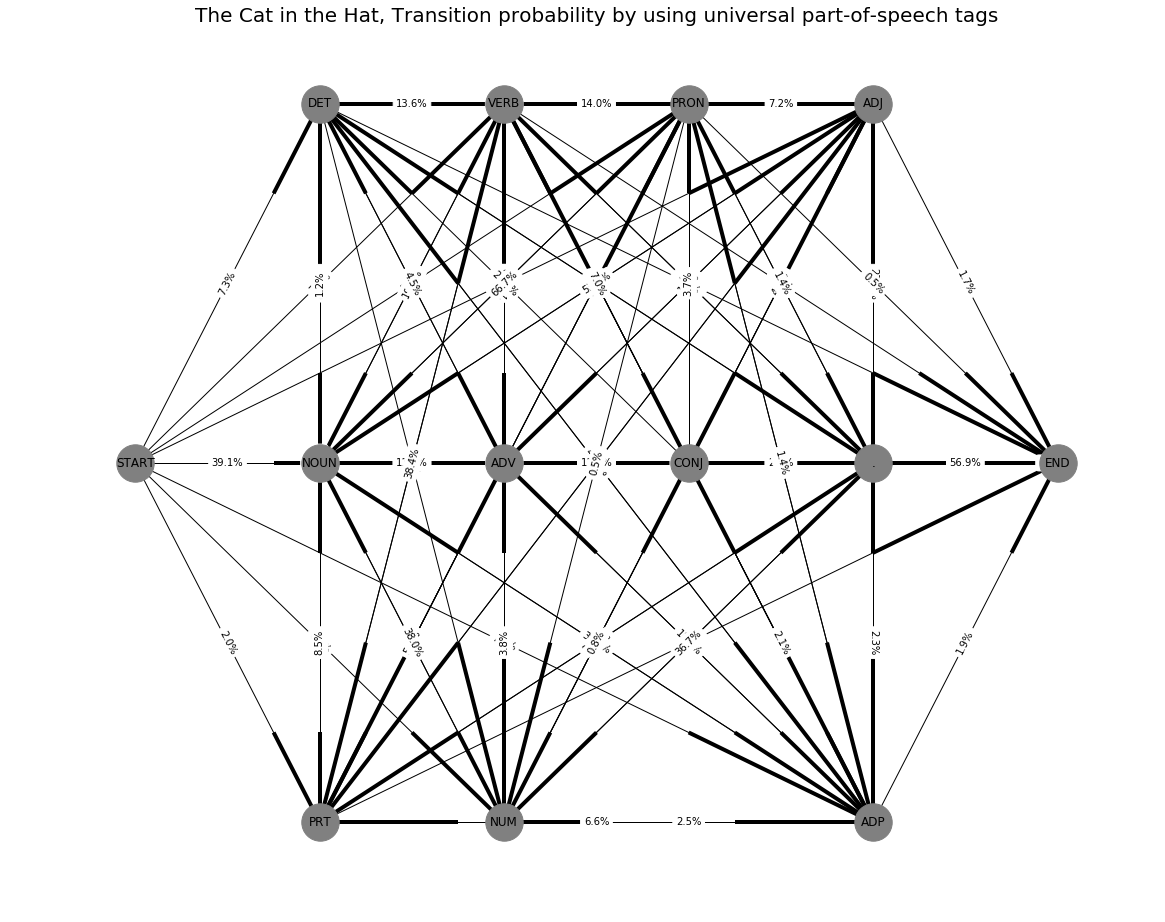

In [18]:
plt.figure(figsize=(20,16))
plt.title('The Cat in the Hat, Transition probability by using universal part-of-speech tags', fontsize=20)

pos = {'START': np.array([0, 0]), 'NOUN': np.array([0.2, 0]), 'ADV': np.array([0.4, 0]), 'CONJ': np.array([0.6, 0]), '.': np.array([0.8, 0]), 'END': np.array([1, 0]), 'DET': np.array([0.2, 0.5]), 'VERB': np.array([0.4, 0.5]), 'PRON': np.array([0.6, 0.5]), 'ADJ': np.array([0.8, 0.5]), 'PRT': np.array([0.2, -0.5]), 'NUM': np.array([0.4, -0.5]), 'ADP': np.array([0.8, -0.5])}
nx.draw_networkx(G, pos)
nx.draw_networkx_nodes(G, pos, node_size=1400, node_color='grey', font_family='sans-serif')
nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
nx.drawing.nx_pydot.write_dot(G, 'uPOS_markov.dot')
plt.axis('off')

In [20]:
# Summarized transition probabilities
tmp

,DET,NOUN,ADP,END,VERB,ADV,.,ADJ,PRT,NUM,CONJ,PRON
START,0.072782,0.390828,0.077767,0.000000,0.071785,0.111665,0.075773,0.022931,0.019940,0.008973,0.109671,0.037886
DET,0.020438,0.700730,0.002920,0.001460,0.081752,0.004380,0.042336,0.116788,0.000000,0.017518,0.000000,0.010219
NOUN,0.012059,0.125323,0.087855,0.038329,0.300603,0.025840,0.342808,0.008183,0.015073,0.003445,0.024978,0.015504
ADP,0.422179,0.309339,0.033074,0.019455,0.013619,0.019455,0.013619,0.038911,0.017510,0.013619,0.001946,0.097276
END,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
VERB,0.136328,0.196747,0.066615,0.011619,0.113091,0.164214,0.137878,0.042603,0.079783,0.017041,0.005422,0.028660
ADV,0.045369,0.115312,0.109641,0.015123,0.224953,0.039698,0.308129,0.079395,0.011342,0.009452,0.022684,0.018904
.,0.034595,0.142298,0.023499,0.568538,0.038512,0.041775,0.075718,0.009791,0.015013,0.007180,0.025457,0.017624
ADJ,0.013289,0.538206,0.029900,0.016611,0.009967,0.013289,0.279070,0.043189,0.019934,0.000000,0.033223,0.003322
PRT,0.137441,0.085308,0.066351,0.014218,0.383886,0.052133,0.208531,0.014218,0.004739,0.000000,0.000000,0.033175


### Emission probabilities per tag

In [81]:
pd.options.display.float_format = '{:,.2f}%'.format
for tag in uPOS_freq.keys():
#     print(tag)
    emitted = (100*pd.Series(uPOS_freq[tag])/sum(uPOS_freq[tag].values())).sort_values(ascending=False)
    display(pd.DataFrame(emitted, columns=[tag]).transpose())

,the,a,this,all,that,some,no,these,every,those,another,an,whose,any,which,whatever
DET,35.62%,30.66%,7.88%,7.01%,5.69%,4.53%,2.48%,1.75%,1.17%,0.88%,0.73%,0.58%,0.44%,0.29%,0.15%,0.15%


,i,you,he,them,we,they,it,sir,fish,house,...,checkerboards,hung,row,slunk,smile,room,guns,roller,drums,boys
NOUN,9.13%,4.44%,4.26%,3.32%,2.80%,2.15%,2.15%,1.55%,1.38%,1.25%,...,0.04%,0.04%,0.04%,0.04%,0.04%,0.04%,0.04%,0.04%,0.04%,0.04%


,in,with,on,of,like,at,for,that,from,if,...,past,while,below,since,toward,around,than,off,walk,down
ADP,24.32%,14.79%,13.04%,9.34%,7.00%,4.86%,3.89%,3.11%,2.92%,2.72%,...,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%


,do,is,will,like,said,are,would,have,can,eat,...,doing,slunk,skates,sir,bicycles,slithered,stockings,bands,lead,knows
VERB,6.82%,6.27%,4.26%,4.03%,3.25%,2.94%,2.87%,2.79%,2.17%,1.94%,...,0.08%,0.08%,0.08%,0.08%,0.08%,0.08%,0.08%,0.08%,0.08%,0.08%


,not,then,so,here,now,n't,there,when,why,too,...,that,nimbly,once,only,rather,instead,together,ask,nervously,close
ADV,26.28%,8.88%,6.62%,5.67%,5.10%,4.91%,3.59%,3.21%,3.21%,2.65%,...,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%,0.19%


,.,",",!,``,'',?,...,:,;
.,36.03%,24.74%,19.84%,6.01%,5.87%,4.77%,2.55%,0.13%,0.07%


,little,good,new,old,big,green,small,red,quick,tweetle,...,likely,sheep,only,sour,busy,mistletoe,grinch,early,young,pet
ADJ,5.32%,5.32%,4.32%,3.32%,3.32%,3.32%,2.99%,2.66%,2.66%,2.66%,...,0.33%,0.33%,0.33%,0.33%,0.33%,0.33%,0.33%,0.33%,0.33%,0.33%


,to,up,oh,down,out,there,no,yell,around,yes,say,back.brown,back,well,away
PRT,49.76%,15.17%,11.37%,5.69%,5.21%,4.27%,3.32%,0.95%,0.95%,0.95%,0.47%,0.47%,0.47%,0.47%,0.47%


,one,two,three,seven,six,four,nine,eight,five,thousand,thoe
NUM,39.24%,30.38%,16.46%,2.53%,2.53%,2.53%,1.27%,1.27%,1.27%,1.27%,1.27%


,and,but,or,so
CONJ,84.36%,9.47%,5.76%,0.41%


,my,what,his,'s,our,who,your,their,her,'
PRON,20.27%,15.77%,13.06%,12.61%,10.36%,8.11%,8.11%,7.66%,2.25%,1.80%


,night.he
NONE,100.00%
